# Credit Default Risk: End-to-End Exploration

Интерактивный ноутбук, показывающий полный цикл: от загрузки и очистки данных до обучения моделей, оценки метрик и интерпретации признаков. Все шаги используют функции из текущего проекта, чтобы ноутбук оставался синхронизированным с основным кодом.


## Содержание
1. Импорт модулей и инициализация
2. Загрузка и предварительный анализ данных
3. Визуализация признаков и распределений
4. Подготовка фичей и разбиение
5. Обучение моделей (CatBoost, Random Forest, Logistic Regression)
6. Сравнение, ROC/PR-кривые и метрики
7. SHAP-анализ и бизнес-интерпретация


In [45]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             roc_curve, precision_recall_curve, classification_report)
from sklearn.model_selection import train_test_split

import sys
from pathlib import Path
PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
PROJECT_ROOT = Path('..').resolve()
os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
import prepare_data as prep
import train_advanced as train_adv
import interpret

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')
pd.set_option('display.max_columns', 120)
RANDOM_STATE = train_adv.RANDOM_STATE
BASE_PATH = train_adv.BASE_PATH


⚠ XGBoost недоступен: XGBoostError
⚠ LightGBM недоступен: OSError
⚠ Optuna недоступна, используем RandomizedSearchCV
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Загрузка исходных данных
Функция `prep.build_master_dataset()` объединяет все источники, нормализует названия колонок, чистит типы и обрезает выбросы. Ниже мы загружаем master-датафрейм и проверяем базовую статистику.


In [46]:
master_df = prep.build_master_dataset()
print(f"Shape: {master_df.shape}")
print("Target distribution:")
print(master_df['default'].value_counts(normalize=True).rename('share'))


FileNotFoundError: [Errno 2] No such file or directory: 'data_sets/application_metadata.csv'

In [47]:
display(master_df.head())


,customer_id,application_id,application_hour,application_day_of_week,account_open_year,preferred_contact,referral_code,account_status_code,random_noise_1,num_login_sessions,num_customer_service_calls,has_mobile_app,paperless_billing,default,credit_score,num_credit_accounts,oldest_credit_line_age,oldest_account_age_months,total_credit_limit,num_delinquencies_2yrs,num_inquiries_6mo,recent_inquiry_count,num_public_records,num_collections,account_diversity_index,age,annual_income,employment_length,employment_type,education,marital_status,num_dependents,monthly_income,existing_monthly_debt,monthly_payment,debt_to_income_ratio,debt_service_ratio,payment_to_income_ratio,credit_utilization,revolving_balance,credit_usage_amount,available_credit,total_monthly_debt_payment,annual_debt_payment,loan_to_annual_income,total_debt_amount,monthly_free_cash_flow,state,regional_unemployment_rate,regional_median_income,regional_median_rent,housing_price_index,cost_of_living_index,previous_zip_code,loan_type,loan_amount,loan_term,interest_rate,loan_purpose,loan_to_value_ratio,origination_channel,loan_officer_id,marketing_campaign
0,10000,620515.0,5,6,2013,Mail,REF0000,ACT-2,1.137099,13,2,1,1,0,696,14,22.0,264.0,169100,0.0,2,2,1,0,0.499,41,61800,2.2,FULL_TIME,Graduate,Married,2,5150.00,738.64,592.13,0.258,0.258402,0.115,0.841,142213.1,142213.1,26886.900,1330.77,15969.24,0.286408,159913.1,3819.230000,OH,4.8,56000,1380.0,91.0,73.0,451,Personal,17700,36,12.50,Debt Consolidation,0.000,Direct Mail,1045,W
1,10001,624978.0,4,2,2015,Phone,REF0000,ACT-3,-0.164932,6,1,1,1,1,659,13,3.5,42.0,78200,0.0,5,5,0,0,0.298,38,28600,7.0,FULL_TIME,High School,Married,0,2383.33,392.21,1013.86,0.590,0.589959,0.425,0.889,75932.2,75932.2,4410.392,1406.07,16872.84,3.986014,189932.2,977.260000,PA,4.4,61000,1510.0,92.0,87.0,537,mortgage,114000,180,6.83,Refinance,0.774,Branch,1011,B
2,10002,564658.0,10,3,2020,Phone,REF0000,ACT-3,0.526700,2,2,1,0,0,662,3,0.0,0.0,41400,0.0,2,2,0,0,0.174,19,20700,0.8,FULL_TIME,Bachelor,Single,0,1725.00,204.07,317.81,0.303,0.302539,0.184,0.539,22314.6,22314.6,19085.400,521.88,6262.56,0.449275,31614.6,1203.120000,VA,3.9,74000,1920.0,125.0,103.0,679,Personal Loan,9300,36,13.99,Major Purchase,0.000,Online,1084,K
3,10003,621493.0,7,5,2010,Email,REF0000,A01,-0.709779,4,1,1,1,0,676,8,9.0,108.0,60000,0.0,1,1,0,0,0.263,27,31400,4.8,FULL_TIME,Bachelor,Single,0,2616.67,288.71,234.52,0.200,0.199961,0.090,0.147,8820.0,8820.0,51180.000,523.23,6278.76,0.277070,17520.0,2093.436667,CA,5.8,75000,1690.0,158.0,121.0,719,PERSONAL,8700,48,13.26,Medical,0.000,Online,1048,A
4,10004,637785.0,1,2,2020,Mail,REF0000,ACT-3,-0.603132,6,2,1,0,0,678,7,8.0,96.0,49700,0.0,1,1,0,0,0.298,26,24600,5.2,FULLTIME,High School,Single,0,2050.00,248.77,334.81,0.285,0.284673,0.163,0.488,24253.6,24253.6,25446.400,583.58,7002.96,0.292683,31453.6,1466.420000,WA,5.8,78000,1700.0,152.0,127.0,933,Personal,7200,24,10.77,Debt Consolidation,0.000,Branch,1055,S


In [32]:
# Обзор пропусков и основных статистик
missing = master_df.isna().mean().sort_values(ascending=False)
display(missing.head(20))
display(master_df.describe(include='all').transpose().head(20))


employment_length             0.025034
revolving_balance             0.015300
num_delinquencies_2yrs        0.009245
customer_id                   0.000000
existing_monthly_debt         0.000000
debt_to_income_ratio          0.000000
debt_service_ratio            0.000000
payment_to_income_ratio       0.000000
credit_utilization            0.000000
credit_usage_amount           0.000000
available_credit              0.000000
total_monthly_debt_payment    0.000000
annual_debt_payment           0.000000
loan_to_annual_income         0.000000
total_debt_amount             0.000000
monthly_free_cash_flow        0.000000
state                         0.000000
regional_unemployment_rate    0.000000
regional_median_income        0.000000
regional_median_rent          0.000000
dtype: float64

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,89999.0,NaN,NaN,NaN,54999.0,25980.617776,10000.0,32499.5,54999.0,77498.5,99998.0
application_id,89999.0,NaN,NaN,NaN,594846.071401,28832.891612,545798.98,569870.5,594901.0,619775.5,643795.02
application_hour,89999.0,NaN,NaN,NaN,11.475539,6.901162,0.0,6.0,11.0,17.0,23.0
application_day_of_week,89999.0,NaN,NaN,NaN,2.993755,2.005926,0.0,1.0,3.0,5.0,6.0
account_open_year,89999.0,NaN,NaN,NaN,2016.497517,4.020588,2010.0,2013.0,2017.0,2020.0,2023.0
preferred_contact,89999,3,Email,54094,NaN,NaN,NaN,NaN,NaN,NaN,NaN
referral_code,89999,7805,REF0000,71987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account_status_code,89999,5,ACT-1,18118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
random_noise_1,89999.0,NaN,NaN,NaN,-0.00012,0.979253,-2.327067,-0.671945,0.003168,0.668945,2.338487
num_login_sessions,89999.0,NaN,NaN,NaN,8.796176,3.751476,2.0,6.0,8.0,11.0,20.0


## 2. Визуализации исходных признаков


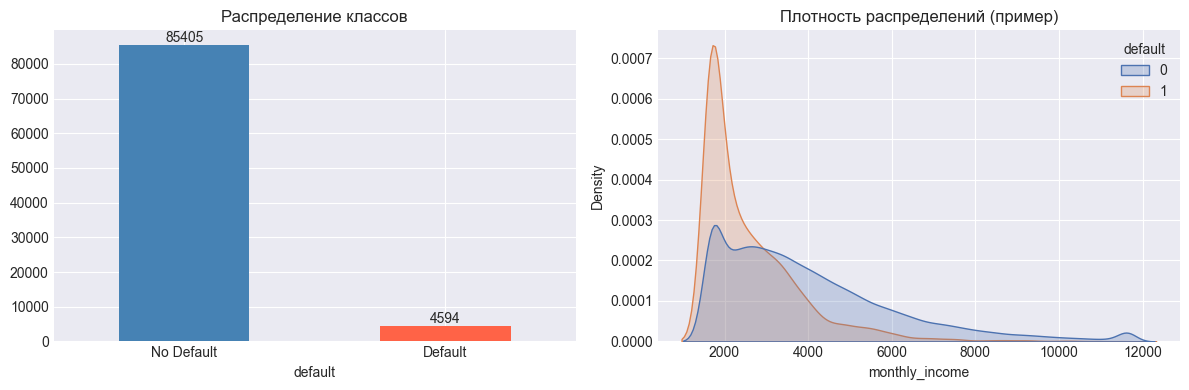

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
class_counts = master_df['default'].value_counts()
class_counts.plot(kind='bar', ax=ax[0], color=['steelblue', 'tomato'])
ax[0].set_title('Распределение классов')
ax[0].set_xticklabels(['No Default', 'Default'], rotation=0)
ax[0].bar_label(ax[0].containers[0])

numeric_preview = ['monthly_income', 'total_monthly_debt_payment', 'credit_score', 'age']
for col in numeric_preview:
    if col in master_df.columns:
        sns.kdeplot(data=master_df, x=col, hue='default', common_norm=False, fill=True, ax=ax[1])
        ax[1].set_title('Плотность распределений (пример)')
        break
plt.tight_layout()


In [ ]:
# Корреляции между топовыми числовыми признаками
numeric_cols = master_df.select_dtypes(include=np.number).columns.tolist()
important_numeric = master_df[numeric_cols].corr()['default'].abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(10, 8))
sns.heatmap(master_df[important_numeric].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляции топовых признаков')


## 3. Подготовка фичей и разбиение
Используем `train_adv.prepare_features_advanced`, чтобы повторить production-пайплайн: обработка пропусков, расширенный feature engineering, кодирование, фильтр inf/NaN.


In [43]:
X, y, feature_cols = train_adv.prepare_features_advanced(master_df)
print(f"Feature matrix: {X.shape}")
print(f"Number of features: {len(feature_cols)}")


⚠ XGBoost недоступен: XGBoostError
⚠ LightGBM недоступен: OSError
   🔧 Создание расширенных признаков...
   ✅ Создано расширенных признаков. Всего признаков: 117
Feature matrix: (89999, 114)
Number of features: 114


In [44]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=RANDOM_STATE, stratify=y_temp)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (57599, 114), Val: (14400, 114), Test: (18000, 114)


## 4. Обучение моделей
Ниже вызываем готовые функции тюнинга из `train_advanced.py`. Эти ячейки могут занять несколько минут из-за RandomizedSearchCV и CatBoost (используются настройки из основного скрипта).


In [37]:
%%time
cb_result = train_adv.train_tuned_catboost(X_train, y_train, X_val, y_val)


      🔍 Настройка гиперпараметров CatBoost...
      📊 Всего будет обучено: 30 моделей
      ⏱ Начало: 19:10:46
      💻 Используются ресурсы CPU (n_jobs=1, thread_count=1)
      🔄 Обучение 30 моделей (sklearn покажет прогресс)...
Fitting 2 folds for each of 15 candidates, totalling 30 fits
0:	learn: 0.7806202	total: 90.7ms	remaining: 27.1s
100:	learn: 0.9032645	total: 2.8s	remaining: 5.51s
200:	learn: 0.9554327	total: 5.63s	remaining: 2.77s
299:	learn: 0.9841027	total: 8.31s	remaining: 0us
0:	learn: 0.7618377	total: 32.4ms	remaining: 9.69s
100:	learn: 0.8952709	total: 2.88s	remaining: 5.68s
200:	learn: 0.9545010	total: 5.82s	remaining: 2.87s
299:	learn: 0.9848620	total: 8.61s	remaining: 0us
0:	learn: 0.7807267	total: 28.8ms	remaining: 8.6s
100:	learn: 0.9106689	total: 3.16s	remaining: 6.22s
200:	learn: 0.9632883	total: 6.47s	remaining: 3.19s
299:	learn: 0.9897758	total: 9.48s	remaining: 0us
0:	learn: 0.7618985	total: 27.3ms	remaining: 8.17s
100:	learn: 0.9026545	total: 2.86s	remaining: 

In [38]:
%%time
rf_result = train_adv.train_tuned_random_forest(X_train, y_train, X_val, y_val)


      🔍 Настройка гиперпараметров Random Forest...
      📊 Всего будет обучено: 16 моделей
      ⏱ Начало: 19:18:59
      💻 Используются ресурсы CPU (n_jobs=1)
      🔄 Обучение...

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   37.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed: 67.9min
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed: 71.1min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   36.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  5.4min
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:  8.4min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    1.

      ✅ Завершено за: 398.9 минут


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s


      ✅ Лучшие параметры: {'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced'}
CPU times: user 44min 33s, sys: 11.5 s, total: 44min 45s
Wall time: 6h 38min 57s


[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.7s finished


In [39]:
%%time
lr_result = train_adv.train_tuned_logistic_regression(X_train, y_train, X_val, y_val)


⚠ XGBoost недоступен: XGBoostError
⚠ LightGBM недоступен: OSError
      🔍 Настройка Logistic Regression с SMOTE...
      ✅ Использован BorderlineSMOTE
      📊 Всего будет обучено: 10 моделей
      ⏱ Начало: 01:57:57
      💻 Используются ресурсы CPU (n_jobs=1)
      ✅ Завершено за: 0.6 минут
      ✅ Лучшие параметры: {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 1}
CPU times: user 39.9 s, sys: 1.81 s, total: 41.7 s
Wall time: 38.4 s


## 5. Сравнение моделей и метрики


In [40]:
model_results = [m for m in [cb_result, rf_result, lr_result] if m]
results_df = pd.DataFrame([{'model': res['name'], 'AUC': res['auc'], 'PR_AUC': res['pr_auc']} for res in model_results])
display(results_df.sort_values('PR_AUC', ascending=False))
best_model = max(model_results, key=lambda x: x['pr_auc'])


,model,AUC,PR_AUC
1,Random Forest (Tuned),0.793958,0.231404
0,CatBoost (Tuned),0.794332,0.230961
2,Logistic Regression (Tuned + SMOTE),0.769754,0.207147


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s


              precision    recall  f1-score   support

           0       0.96      0.98      0.97     13665
           1       0.34      0.20      0.25       735

    accuracy                           0.94     14400
   macro avg       0.65      0.59      0.61     14400
weighted avg       0.93      0.94      0.93     14400



[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    0.8s finished


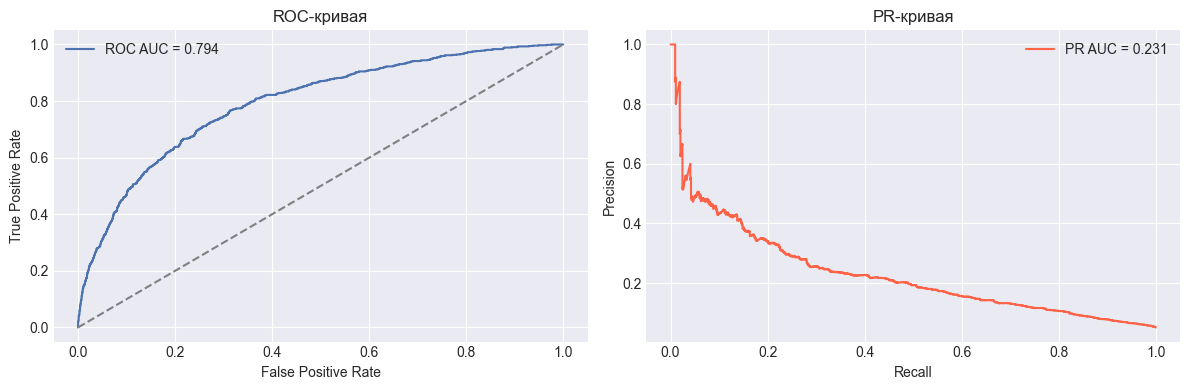

In [41]:
# ROC и PR-кривые на валидации
model = best_model['model']
scaler = best_model.get('scaler')
X_eval = scaler.transform(X_val) if scaler else X_val
y_scores = model.predict_proba(X_eval)[:, 1]
roc_auc = roc_auc_score(y_val, y_scores)
pr_auc = average_precision_score(y_val, y_scores)

fpr, tpr, _ = roc_curve(y_val, y_scores)
prec, rec, _ = precision_recall_curve(y_val, y_scores)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
ax[0].plot([0, 1], [0, 1], '--', color='gray')
ax[0].set_title('ROC-кривая')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()

ax[1].plot(rec, prec, label=f'PR AUC = {pr_auc:.3f}', color='tomato')
ax[1].set_title('PR-кривая')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend()
plt.tight_layout()
print(classification_report(y_val, (y_scores >= 0.5).astype(int)))


## 6. SHAP-анализ и интерпретация
Используем модуль `interpret.py` для расчета SHAP значений и топ-10 важных признаков, а также для визуализации summary plot.


In [42]:
model_data = {
    'model': best_model['model'],
    'scaler': best_model.get('scaler'),
    'model_name': best_model['name']
}
shap_result = interpret.compute_shap_values(model_data, pd.DataFrame(X_val, columns=feature_cols), n_samples=300)
if shap_result:
    top_features = interpret.get_top_features_shap(shap_result, top_n=10)
    display(top_features)
else:
    print('SHAP не был рассчитан (см. логи выше).')


ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
if shap_result:
    shap.summary_plot(shap_result['shap_values'], shap_result['X_shap'], feature_names=shap_result['feature_names'])


## 7. Следующие шаги
- Запустить `interpret.interpret_feature_impact` для ключевых признаков и сформировать бизнес-выводы.
- Сохранить ноутбук в презентацию (экспорт HTML/PDF).
- Подставить итоговую модель в прод: использовать `train_advanced.main()` или `models/best_model_advanced.pkl`.
